In [79]:
import json, os
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import itertools


In [80]:
# '1a-basic-flow'
# '1b-basic-flow'
# '2-expr-binary-ops'
# '3a-expr-func-calls'

TEST_SlICE = '1a-basic-flow'

In [81]:
with open(os.path.join('testSlices', TEST_SlICE + '.json')) as json_file:
    slices = json.load(json_file)

with open(os.path.join('testPatterns', TEST_SlICE + '.patterns.json')) as json_file:
    patterns = json.load(json_file)

Initialize Classes

In [82]:
class Stmt_Expression():
    def __init__(self, expr):
        self.expr = expr
    
    def __repr__(self):
        return f"Stmt_Expression({self.expr})"

class Expr_Assign():
    def __init__(self, var, list_expr):
        self.var = var
        self.list_expr = list_expr
    def __repr__(self):
        str_list_expr = ", ".join(str(expr) for expr in self.list_expr)
        return f"{self.var} = {str_list_expr}"

class Expr_FuncCall():
    def __init__(self, name, args=[]):
        self.name = name
        self.args = args
    def __str__(self):
        str_args = ", ".join(str(arg) for arg in self.args)
        return f"{self.name}({str_args})"
    def __repr__(self):
        return f"{self.name}()"

class Stmt_If():
    def __init__(self, condition,codeBlock, elseIfs, elseBlock):
        self.condition = condition # Do we even need the condition?
        self.codeBlock = codeBlock
        self.elseIfs = elseIfs
        self.elseBlock = elseBlock
    def __str__(self):
        printString = f"if({self.condition})[\n{self.codeBlock}]"
        if not self.elseIfs.steps == []:
            printString += f"elseIf[\n{str(self.elseIfs)}]"
        if not self.elseBlock is None:
            printString += f"else[\n{str(self.elseBlock)}]"
        return printString
    def __repr__(self):
        return str(self)

class Stmt_Else():
    def __init__(self,block):
        self.block = block
    def __str__(self):
        return str(self.block)
    def __repr__(self):
        return str(self)


class Expr_Variable():
    def __init__(self, name):
        self.name = name
    def __repr__(self):
        return f"${self.name}"
    #def __eq__(self, other):
        # Check if the other object is an Assignment and has the same left and right values
    #    if isinstance(other, Expr_Variable) and self.name == other.name:
    #        return True
    #    return False
    #def __hash__(self):
        # Return a unique and immutable value based on the left and right values
    #    return hash(self.name)

class Constant():
    def __init__(self, value):
        self.value = value
    def __repr__(self):
        return f"Constant(value={self.value})"

class Stmt_Nop():
    def __init__(self, value):
        self.value = value
    def __repr__(self):
        return f"Nop(value={self.value})"
        

class Expr_BinaryOp_Concat():
    def __init__(self, left, right):
        self.left = left
        self.right = right
    def __repr__(self):
        return f"{self.left}, {self.right}"

class Expr_BinaryOp_Greater():
    def __init__(self, left, right):
        self.left = left
        self.right = right
    def __repr__(self):
        return f"{self.left}>{self.right}"

class Expr_BinaryOp_Smaller():
    def __init__(self, left, right):
        self.left = left
        self.right = right
    def __repr__(self):
        return f"{self.left}<{self.right}"


class Program():
    def __init__(self, steps):
        self.steps = steps
    def __repr__(self):
        str_steps = '\n'.join(f'\t{idx}. {step}' for idx, step in enumerate(self.steps))
        return f'\n{str_steps}\n'

Recusive Function to convert the input slices into class objects

In [83]:
def flatten(lst):
    flat_list = []
    for item in lst:
        if isinstance(item, list):
            flat_list.extend(flatten(item))
        else:
            flat_list.append(item)
    return flat_list
    
def process_json(obj):
    if isinstance(obj, dict):
        if obj["nodeType"] == 'Stmt_Else':
            block = process_json(obj["stmts"])
            return Stmt_Else(block)
        if obj["nodeType"] == 'Stmt_If':
            condition = process_json(obj["cond"])
            codeBlock = process_json(obj["stmts"])
            elseIfs = process_json(obj["elseifs"])
            elseBlock = process_json(obj["else"])
            return Stmt_If(condition, codeBlock, elseIfs, elseBlock)
        if obj["nodeType"] == 'Stmt_Expression':
            #expr = process_json(obj["expr"])
            #return Stmt_Expression(expr)
            return process_json(obj["expr"])
        if obj["nodeType"] == "Expr_Assign":
            var = process_json(obj["var"])
            list_expr = [process_json(obj["expr"])]
            return Expr_Assign(var, list_expr)
        if obj["nodeType"] == "Expr_FuncCall":
            name = obj["name"]["parts"][0]
            args = flatten([process_json(arg) for arg in obj["args"]])
            return Expr_FuncCall(name, args)
        if obj["nodeType"] == "Expr_BinaryOp_Concat":
            left = process_json(obj["left"])
            right = process_json(obj["right"])
            return flatten([left, right])
        if obj["nodeType"] == "Expr_BinaryOp_Greater":
            left = process_json(obj["left"])
            right = process_json(obj["right"])
            return Expr_BinaryOp_Greater(left, right)
        if obj["nodeType"] == "Expr_BinaryOp_Smaller":
            left = process_json(obj["left"])
            right = process_json(obj["right"])
            return Expr_BinaryOp_Smaller(left, right)
        if obj["nodeType"] == "Arg":
            return process_json(obj["value"])
        if obj["nodeType"] == "Expr_Variable":
            return Expr_Variable(obj["name"])
        if obj["nodeType"] == "Scalar_String":
            return Constant(obj["value"])
        if obj["nodeType"] == "Scalar_LNumber":
            return Constant(obj["value"])
        if obj["nodeType"] == "Stmt_Nop":
            return Stmt_Nop("Nop")
    elif isinstance(obj, list):
        #for item in obj:
        steps = [process_json(step) for step in obj]
        return Program(steps)
    else:
        # this is for error catching :)
        print(obj)

# Process the JSON object
parsed_ast = process_json(slices)

Print the program in a readable format

In [84]:
print(parsed_ast)


	0. $a = Constant(value=)
	1. $b = c()
	2. d($a)
	3. e($b)
	4. Nop(value=Nop)



In [85]:
class CustomGraph:
    def __init__(self, name):
        self.nodes = []
        self.edges = []
        self.name = name

    def add_node(self,node):
        self.nodes.append(node)
        
    def remove_node(self,node):
        self.nodes.remove(node)

    def add_edge(self,firstNode, secondNode):
        if firstNode not in self.nodes:
            self.nodes.append(firstNode)
        if secondNode not in self.nodes:
            self.nodes.append(secondNode)
        self.edges.append((firstNode,secondNode))

    def remove_edge(self, firstNode, secondNode):
        self.edges.remove((firstNode, secondNode))

    def has_node(self, node, evalMode=False):
        if evalMode:
            return str(node) in [repr(n) for n in self.nodes]
        else:
            return node in self.nodes

    def in_edges(self, node):
        edgesFound = []
        for edge in self.edges:
            if node in edge:
                edgesFound.append(edge)
        return edgesFound

    def successors(self,node):
        successors = []
        for pair in self.edges:
            if pair[0] == node:
                successors.append(pair[1])
        return successors
    
    def add_edges_from(self, edges):
        for edge in edges:
            if edge not in self.edges:
                self.edges.append(edge)
    
    def __repr__(self):
        return f"{self.name}"

Recusively create a graph based on the program

In [86]:
codeBlockCounter = 1

# Function to recursively find all assignments in the AST
def create_graph(node, programGraph, graph):
    global codeBlockCounter

    if isinstance(node, Expr_Assign):

        if graph.has_node(str(node.var)):
            # If the variable isn't referenced anywhere, it is overwritten
            if len(list(graph.successors(str(node.var)))) == 0:
                for u, v in list(graph.in_edges(str(node.var))):
                    graph.remove_edge(u, v)
                    graph.remove_node(u)

        for expr in node.list_expr:
            if isinstance(expr, Expr_FuncCall):
                graph.add_edge(repr(expr), str(node.var))
                create_graph(expr, programGraph, graph)
            if isinstance(expr, Expr_Variable):
                graph.add_edge(str(expr), str(node.var))

    if isinstance(node, Expr_FuncCall):
        for arg in node.args:
            graph.add_edge(str(arg), repr(node))

    if isinstance(node, Stmt_Else):
        create_graph(node.block, programGraph,graph)  

    if isinstance(node, Stmt_If):
        #validate if there is assignment in the if condiction (it is possible!) # @Arne: ????
        create_graph(node.condition, programGraph, graph)
        
        #we generate a code block for if the statement is true
        codeBlockCounter += 1
        new_ifGraph = CustomGraph(f"ifcodeBlock#{codeBlockCounter}")
        programGraph.add_edge(graph, new_ifGraph)
        connectifGraph = create_graph(node.codeBlock, programGraph, new_ifGraph)
        
        
        #FIXME This may need to change, need to test with else ifs
        if node.elseIfs.steps != []:
            codeBlockCounter += 1
            new_ifGraph2 = CustomGraph(f"elifscodeBlock#{codeBlockCounter}")
            create_graph(node.elseIfs, programGraph, new_ifGraph2)
            programGraph.add_edge(graph, new_ifGraph2)
        
        #This is the else codeblock
        codeBlockCounter += 1
        new_elseGraph = CustomGraph(f"elsecodeBlock#{codeBlockCounter}")
        connectelseGraph =create_graph(node.elseBlock, programGraph,new_elseGraph)
        programGraph.add_edge(graph, new_elseGraph)
        

        #This is a new codeblock after the if and else statement
        #where I connect the if and else block to this new block
        #With the 4a example its the 5 and 7 blocks
        codeBlockCounter += 1
        new_endifGraph = CustomGraph(f"codeBlock#{codeBlockCounter}")
        programGraph.add_edge(connectelseGraph, new_endifGraph)
        programGraph.add_edge(connectifGraph, new_endifGraph)
        graph = new_endifGraph

    if hasattr(node, 'steps'):
        for step in node.steps:
            create_graph(step, programGraph, graph)


# Create a graph for the code blocks
graph = CustomGraph(f"codeBlock#{codeBlockCounter}")

# Create a graph for the whole program
programGraph = CustomGraph("ProgramGraph")
programGraph.add_node(graph)

# Recusrively create the Program Graph consisting of graphs
create_graph(parsed_ast, programGraph, graph)

Print the  program graph  and each single blocks graph

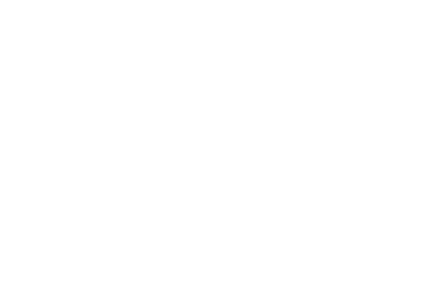

codeBlock#1


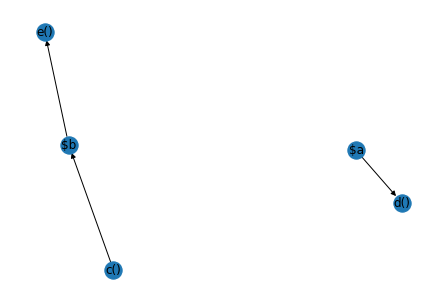

[codeBlock#1]


In [87]:
# Use NetworkX's draw() function to draw the graph
debugGraph = nx.DiGraph()
debugGraph.add_edges_from(programGraph.edges)
nx.draw(debugGraph, with_labels=True)
plt.show()

# Loop through each codeBlocks graph and draw it
for nodeGraph in programGraph.nodes:
    print(nodeGraph)
    debugGraph = nx.DiGraph()
    debugGraph.add_edges_from(nodeGraph.edges)
    nx.draw(debugGraph, with_labels=True)
    plt.show()


# Display the graph

print(programGraph.nodes)


Function to generate all possible paths from the first node to the end node 

In [88]:
def getPossiblePaths(programGraph):
    def fillneighbours(programGraph):
        neighbours = {}
        for edge in programGraph.edges:
            if edge[0] not in neighbours.keys():
                neighbours[edge[0]] = [edge[1]]
            else:
                neighbours[edge[0]].append(edge[1])
        return neighbours
    def getPaths(visited, neighbours, node, endNode):
        if node == endNode:
            paths.append(visited)
        if node not in neighbours.keys():
            return 
        for neighbour in neighbours[node]:
            getPaths(visited + [neighbour,], neighbours, neighbour, endNode)

    #Output struture
    paths = []
    #This is a support structure to make it easier to traverse each nodes neighbours
    neighbours = fillneighbours(programGraph)
    getPaths([programGraph.nodes[0]], \
            neighbours, programGraph.nodes[0],\
            programGraph.nodes[len(programGraph.nodes)-1])
    return paths

Example on how to join each path into a single graph

[codeBlock#1]


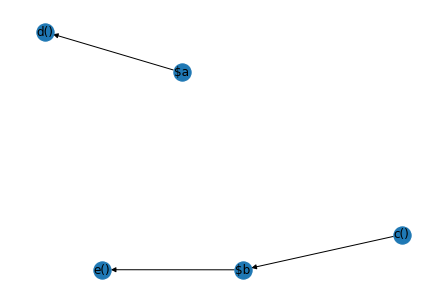

In [90]:
listOfCombinations = getPossiblePaths(programGraph)

for combination in listOfCombinations:
    print(combination)
    debugGraph = nx.DiGraph()
    for graph in combination:
        debugGraph.add_edges_from(graph.edges)
    nx.draw(debugGraph, with_labels=True)
    plt.show()

    

In [100]:
def get_paths(graph, start, path=[]):
    path = path + [start]
    if not graph.has_node(start, evalMode=True):
        return []
    paths = []
    for node in graph.successors(start):
        new_paths = get_paths(graph, node, path)
        for new_path in new_paths:
            paths.append(new_path)
    if not paths:
        paths.append(path)
    return paths

def create_output_list(list_output: list, new_vulnerability: json) -> list:
    EXISTS = False
    for idx, known_vulnerability in enumerate(list_output):
        if all(known_vulnerability[key] == new_vulnerability[key] for key in ["vulnerability", "source", "sink"]):
            EXISTS = True
            if len(new_vulnerability["sanitized flows"]) == 0:
                list_output[idx]["unsanitized flows"] = "yes"
            else:
                list_output[idx]["sanitized flows"].append(new_vulnerability["sanitized flows"])
    if not EXISTS:
        list_output.append(new_vulnerability)
    return list_output
    
def analyze_patterns(pattern: dict, graph: CustomGraph) -> dict:
    list_output = []
    for source in pattern["sources"]:
        if "$" not in source: # FIXME: Maybe remove this from the graph 
            source += "()"
        print(source)
        possible_paths = get_paths(graph, source)
        print(possible_paths)
        for sink in pattern["sinks"]:
            if "$" not in sink:
                sink += "()"
            for path in possible_paths:
                if sink in path:
                    if pattern["implicit"] == 'yes' or (pattern["implicit"] == 'no' and path.index(sink) > 0):
                        sanitizers = []
                        for sanitize_func in pattern["sanitizers"]:
                            if sanitize_func + "()" in path:
                                if path.index(sanitize_func + "()") < path.index(sink):
                                    sanitizers.append(sanitize_func + "()")
                        
                        list_output = create_output_list(
                            list_output = list_output, 
                            new_vulnerability = {
                                "vulnerability": pattern["vulnerability"],
                                "source": source,
                                "sink": sink,
                                "unsanitized flows": "yes" if len(sanitizers) == 0 else "no",
                                "sanitized flows": sanitizers
                            }
                        )
                        

    return list_output

In [101]:
def getAllPossibleGraphs(lst:list) -> list:
    if isinstance(lst[0], CustomGraph):
        return_graph = CustomGraph(name="Final")
        for graph in lst:
            return_graph.add_edges_from(graph.edges)
        return return_graph
    if isinstance(lst[0], list):
        return [getAllPossibleGraphs(combination) for combination in lst] 
    
listOfCombinations = getPossiblePaths(programGraph)
listOfGraphs = getAllPossibleGraphs(listOfCombinations)

In [102]:
output = []
for graph in listOfGraphs:
    print(graph)
    for pattern in patterns:
        output.extend(analyze_patterns(pattern, graph))
print(output)

Final
c()
[]
[]
